# Microchip Quality Assurance using Regularized Logistic Regression

## Environment Setup

Before we begin building our classification model, we need to import the essential Python libraries:
* **Pandas**: For data manipulation and loading our microchip dataset.
* **NumPy**: For efficient vectorized computations and matrix operations.
* **Matplotlib**: For visualizing the data and our final decision boundaries.

In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


#### Sigmoid Function

The logistic regression hypothesis is defined as:

$$ h_\theta(x) = g(\theta^T x) $$

where $g$ is the sigmoid function. The sigmoid function is defined as:

$$ g(z) = \frac{1}{1+e^{-z}} $$

In this project, the first step is to implement the `sigmoid` function, which will be used throughout the program.  
The function should support scalar, vector, and matrix inputs, applying the sigmoid function element-wise.  

This function serves as the foundation for computing probabilities in logistic regression.


In [184]:
def sigmoid(z):
    """
    Compute sigmoid function given the input z.

    Parameters
    ----------
    z : array_like
        The input to the sigmoid function. This can be a 1-D vector
        or a 2-D matrix.

    Returns
    -------
    g : array_like
        The computed sigmoid function. g has the same shape as z, since
        the sigmoid is computed element-wise on z.
    """

    g = 1 / (1 + np.exp(-z))
    return g

The parameter $\theta_0$ represents the bias term in the model's weights.  

In this project, the function `cost_function` is implemented to compute the cost value, and `gradient_descent` is defined to return the gradient.  

The logistic regression cost function is defined as:

$$ J(\theta) = \frac{1}{m} \sum_{i=1}^{m} \left[ -y^{(i)} \log\left(h_\theta\left( x^{(i)} \right) \right) - \left( 1 - y^{(i)}\right) \log \left( 1 - h_\theta\left( x^{(i)} \right) \right) \right]$$

and the gradient of the cost is a vector of the same length as $\theta$, with the $j^{th}$ element (for $j = 0, 1, \cdots , n$) given by:

$$ \frac{\partial J(\theta)}{\partial \theta_j} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left( x^{(i)} \right) - y^{(i)} \right) x_j^{(i)} $$

Although the gradient formula looks similar to the linear regression gradient, it differs because the hypothesis function $h_\theta(x)$ is defined differently in logistic regression.


In [185]:
def cost_function(theta, X, y):
    """
    Compute cost_function for logistic regression.

    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).

    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the
        intercept has already been added to the input.

    y : arra_like
        Labels for the input. This is a vector of shape (m, ).

    Returns
    -------
    J : float
        The computed value for the cost function.
    """
    m = y.size
    # 1. Prediction: Calculate the probability (h) for all samples at once
    h = sigmoid(X.dot(theta))
    
    # 2. Stability: Prevent log(0) which results in NaN (Not a Number)
    h = np.clip(h, 1e-10, 1 - 1e-10)
    
    # 3. Vectorized Cost Calculation: 
    term1 = y * np.log(h)
    term2 = (1 - y) * np.log(1 - h)
    
    J = - (1 / m) * np.sum(term1 + term2)
    
    return J

In [186]:
def gradient_descent(theta, X, y):
    """
    Compute gradient_descent for logistic regression.

    Parameters
    ----------
    theta : array_like
        The parameters for logistic regression. This a vector
        of shape (n+1, ).

    X : array_like
        The input dataset of shape (m x n+1) where m is the total number
        of data points and n is the number of features. We assume the
        intercept has already been added to the input.

    y : arra_like
        Labels for the input. This is a vector of shape (m, ).

    Returns
    -------
    grad : array_like
        A vector of shape (n+1, ) which is the gradient of the cost
        function with respect to theta, at the current values of theta.
    """
    m = y.size
    # 1. Prediction: Compute probabilities using the sigmoid of X*theta
    h = sigmoid(X.dot(theta))
    
    # 2. Vectorized Gradient Calculation:
    grad = (1 / m) * X.T.dot(h - y)
    
    return grad

### Model Evaluation
To evaluate the performance of our trained model, we implement a `predict` function. 
This function uses the learned parameters ($\theta$) to calculate the probability of a positive outcome via the sigmoid function. 
A threshold of 0.5 is applied to classify each instance as either a "Pass" (1) or a "Fail" (0).

In [187]:
def predict(theta, X):
    """
    Predict whether the label is 0 or 1 using learned logistic regression.
    Computes the predictions for X using a threshold at 0.5
    (i.e., if sigmoid(theta.T*x) >= 0.5, predict 1)

    Parameters
    ----------
    theta : array_like
        Parameters for logistic regression. A vecotor of shape (n+1, ).

    X : array_like
        The data to use for computing predictions. The rows is the number
        of points to compute predictions, and columns is the number of
        features.

    Returns
    -------
    p : array_like
        Predictions and 0 or 1 for each row in X.
    """
    predicted = np.round(sigmoid(X.dot(theta)))

    return predicted

In this project, a regularized logistic regression model is implemented to predict whether microchips from a fabrication plant pass quality assurance (QA) based on test results. The model evaluates microchip performance using data from two different tests to determine if a unit should be accepted or rejected. To account for non-linear decision boundaries and prevent overfitting, this implementation incorporates feature mapping and L2 regularization, ensuring a robust classification of past and future test results.

The following section loads the dataset and its corresponding labels from a CSV file.

In [188]:
microchips= pd.read_csv("../data/microchips_data.csv", names=["First_Test", "Second_Test", "Status"])
# type casting from pandas series and pandas dataframe to numpy array
X = np.array(microchips[["First_Test", "Second_Test"]])
y = np.array(microchips["Status"])
# size of dataset
number_of_samples = y.size
# size of X matrix, m= rows, n= features
m,n = X.shape
print('size of samples: {}'.format(number_of_samples))

size of samples: 118


### 1. Data Visualization
Before building the model, we visualize the dataset to understand the distribution of the test results. 
The plot below displays the relationship between the two tests, with green points representing microchips that passed quality assurance and red points representing those that failed. 
This visualization confirms that the classes are not linearly separable, justifying the need for a non-linear approach.

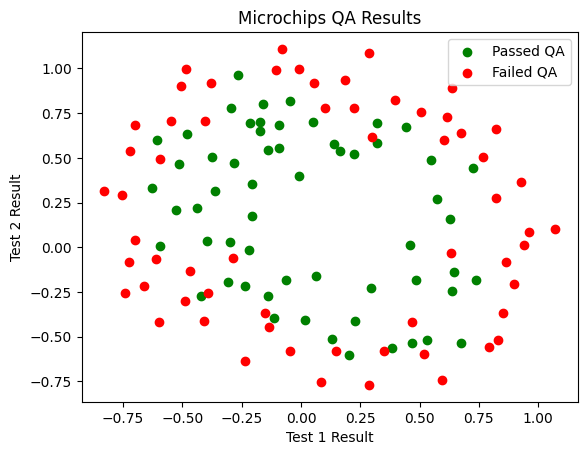

In [189]:
# Separate the dataset into two classes based on the QA status
passed_microchips = microchips[microchips["Status"] == 1]
failed_microchips = microchips[microchips["Status"] == 0]

# Plot the test results for both classes
plt.scatter(passed_microchips["First_Test"], passed_microchips["Second_Test"], 
            color="green", label="Passed QA")
plt.scatter(failed_microchips["First_Test"], failed_microchips["Second_Test"], 
            color="red", label="Failed QA")

# Format the plot with titles and labels
plt.title("Microchips QA Results")
plt.xlabel("Test 1 Result")
plt.ylabel("Test 2 Result")
plt.legend()
plt.show()

### 2. Feature mapping
Feature Engineering: Polynomial Mapping  
As observed in the visualization, the data points are not linearly separable. A standard linear decision boundary would fail to capture the underlying patterns of the dataset. To address this, we apply Feature Mapping to transform our initial two-dimensional input into a higher-dimensional space.

By generating all polynomial combinations of the features up to the sixth power, we expand our feature vector from 2 to 28 dimensions. This transformation allows the logistic regression model to learn a complex, non-linear decision boundary that can effectively encircle the "Passed" samples.

Note on Overfitting: While increasing the number of features makes the model more expressive, it also significantly increases the risk of overfitting, where the model learns the noise in the training data rather than the general trend. To mitigate this, we will implement Regularization in the following sections to ensure the model generalizes well to new, unseen data.

In [190]:
def map_feature(X1, X2, degree=6):
    """
    Feature mapping function to expand the feature space into polynomial terms.
    
    Maps two input features to polynomial terms up to the specified degree:
    [1, x1, x2, x1^2, x1*x2, x2^2, ..., x2^6]

    Parameters
    ----------
    X1, X2 : ndarray
        Input features (vectors) of shape (m,).
    degree : int, optional
        The maximum polynomial degree. Default is 6.

    Returns
    -------
    ndarray
        A feature matrix of shape (m, 28) for degree 6.
    """
    out = [np.ones(X1.shape[0])]
    
    for i in range(1, degree + 1):
        for j in range(i + 1):
            # Calculate polynomial combinations: (X1^(i-j) * X2^j)
            new_col = (X1 ** (i - j)) * (X2 ** j)
            out.append(new_col)
            
    return np.column_stack(out)

In [191]:
X = map_feature(X[:,0], X[:,1])

### 3. Regularized Cost Function and Gradient

To handle the complexity of the 28-dimensional feature space and prevent overfitting, we implement **L2 Regularization**. The objective is to penalize large weights ($\theta$) by adding a regularization term to our cost function.

The regularized cost function $J(\theta)$ is defined as:

$$J(\theta) = \frac{1}{m} \sum_{i=1}^m \left[ -y^{(i)}\log \left( h_\theta \left(x^{(i)} \right) \right) - \left( 1 - y^{(i)} \right) \log \left( 1 - h_\theta \left( x^{(i)} \right) \right) \right] + \frac{\lambda}{2m} \sum_{j=1}^n \theta_j^2$$

#### Implementation Details:
* **The Bias Term:** It is important to note that $\theta_0$ (the intercept) is **not** regularized.
* **The Gradient:** The gradient calculation is split to ensure the penalty is only applied to $\theta_1, \dots, \theta_n$:

$$\frac{\partial J(\theta)}{\partial \theta_0} = \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_0^{(i)}$$

$$\frac{\partial J(\theta)}{\partial \theta_j} = \left( \frac{1}{m} \sum_{i=1}^m \left( h_\theta \left(x^{(i)}\right) - y^{(i)} \right) x_j^{(i)} \right) + \frac{\lambda}{m}\theta_j \quad \text{for } j \ge 1$$

The following function implements both the cost and the gradient in a vectorized manner for efficiency.

In [192]:
def cost_function_gradient_descent_regularized(theta, X, y, lambda_):
    """
    Compute cost and gradient for logistic regression with regularization.
    """
    m = y.size  # Number of training examples
    n = len(theta) # Number of features (including intercept)

    # --- Cost Calculation ---
    # We use the existing cost_function for the base loss
    J = cost_function(theta, X, y)
    
    # Regularization term: sum of squares of theta from index 1 to n
    # We skip theta[0] (the bias term)
    reg_term = (lambda_ / (2 * m)) * np.sum(np.square(theta[1:]))
    J += reg_term

    # --- Gradient Calculation ---
    # We use the existing gradient_descent for the base gradient
    grad = gradient_descent(theta, X, y)
    
    # Add regularization to the gradient (except for theta[0])
    grad[1:] += (lambda_ / m) * theta[1:]

    return J, grad

### 3.1. Model Training with Momentum and Regularization

To find the optimal parameters $\theta$, we utilize the **Momentum** optimization algorithm. This approach helps accelerate the gradient descent process and navigate the 28-dimensional cost surface more efficiently than standard gradient descent.

In this stage, we evaluate the model under two specific scenarios:
* **$\lambda = 1$ (Regularized):** A balanced approach designed to prevent overfitting by penalizing large weights, ensuring the decision boundary remains smooth.
* **$\lambda = 0$ (No Regularization):** The model is trained without a penalty term. This allows us to observe how the decision boundary behaves when it is forced to fit the training data as closely as possible, often leading to a more complex and "wiggly" boundary.

The goal is to compare these two states and observe how regularization affects the model's ability to generalize.

In [193]:
def train_using_momentum(theta, X, y, learning_rate, beta, lmbda, epochs=500):
    """
    Train the Regularized logistic regression model using Stochastic Gradient Descent with Momentum.
    """
    m = y.size
    v = np.zeros(theta.shape)
    
    for epoch in range(epochs):
        # Shuffle the data at the start of each epoch
        indices = np.random.permutation(m)
        X_shuffled = X[indices]
        y_shuffled = y[indices]
        
        for i in range(m):
            xi = X_shuffled[i]
            yi = y_shuffled[i]

            # Compute prediction error for a single sample
            prediction = sigmoid(np.dot(xi, theta))
            grad = (prediction - yi) * xi
            
            # Add L2 Regularization to the gradient (excluding theta[0])
            # np.r_ creates a vector where the first element is 0, followed by theta[1:]
            reg_term = (lmbda / m) * np.r_[[0], theta[1:]]
            grad += reg_term

            # Update velocity and parameters
            v = beta * v + (1 - beta) * grad
            theta -= learning_rate * v

    return theta

### Model Evaluation and Accuracy
After training the model using the Momentum optimizer with $\lambda = 1$, we evaluate its performance by calculating the classification accuracy on the training set. This tells us the percentage of microchips the model correctly classified.

In [194]:
# Compute accuracy on our training set
initial_theta = np.zeros(X.shape[1])
theta_optimized = train_using_momentum(initial_theta, X, y, 0.01,0.9,1)
model_predicted = predict(theta_optimized, X)

print("Train Accuracy: {:.1f}".format((np.mean(model_predicted == y) * 100)))
print("Expected accuracy (with lambda = 1): 83.1 % (approx)\n")

Train Accuracy: 83.1
Expected accuracy (with lambda = 1): 83.1 % (approx)



### Visualizing the Decision Boundary ($\lambda = 1$)

With regularization enabled ($\lambda = 1$), the model strikes a balance between fitting the training data and keeping the weights small. This results in a smoother, more circular decision boundary that generalizes better to new data. Unlike the next plot, this boundary is less sensitive to individual outliers, demonstrating the power of L2 regularization in preventing overfitting.

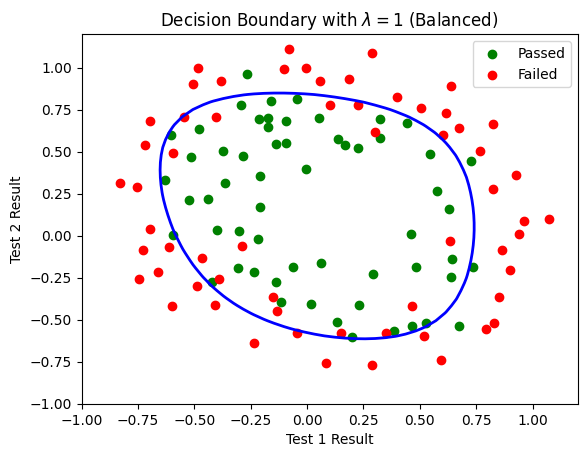

In [195]:
# Train the model with lambda = 1 (Regularized)
initial_theta = np.zeros(X.shape[1])
theta_lamda1 = train_using_momentum(initial_theta, X, y, 0.01, 0.9, 1)

# Create a grid for the contour plot
u = np.linspace(-1, 1.2, 50)
v = np.linspace(-1, 1.2, 50)
z = np.zeros((50, 50))

# Evaluate the model's predictions over the grid
for i in range(50):
    for j in range(50):
        features = map_feature(np.array([u[i]]), np.array([v[j]]))
        z[i, j] = np.dot(features, theta_lamda1).item()

# Transpose z and plot the data and boundary
z = z.T 
plt.scatter(passed_microchips["First_Test"], passed_microchips["Second_Test"], color="green", label="Passed")
plt.scatter(failed_microchips["First_Test"], failed_microchips["Second_Test"], color="red", label="Failed")

# Draw the boundary at z = 0
plt.contour(u, v, z, levels=[0], linewidths=2, colors='b')

plt.title(r"Decision Boundary with $\lambda = 1$ (Balanced)")
plt.xlabel("Test 1 Result")
plt.ylabel("Test 2 Result")
plt.legend()
plt.show()

### Visualizing the Decision Boundary ($\lambda = 0$)

When regularization is disabled ($\lambda = 0$), the model focuses entirely on minimizing the training error. This often results in a complex, non-linear boundary that attempts to capture every data point, potentially leading to **overfitting**. 

The plot below visualizes how the 28-dimensional polynomial features create a non-linear separation in the original 2D feature space.

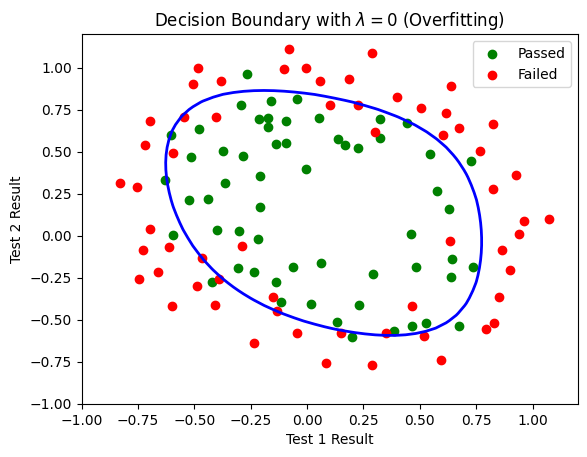

In [196]:
# Train the model with lambda = 0 (No Regularization)
initial_theta = np.zeros(X.shape[1])
theta_lamda0 = train_using_momentum(initial_theta, X, y, 0.01, 0.9, 0)

# Create a grid for the contour plot
u = np.linspace(-1, 1.2, 50)
v = np.linspace(-1, 1.2, 50)
z = np.zeros((50, 50))

# Evaluate the model's predictions over the grid
for i in range(50):
    for j in range(50):
        # Map features to the same 6th degree polynomial used in training
        features = map_feature(np.array([u[i]]), np.array([v[j]]))
        z[i, j] = np.dot(features, theta_lamda0).item()

# Transpose z to align with axis and plot the boundary
z = z.T 
plt.scatter(passed_microchips["First_Test"], passed_microchips["Second_Test"], color="green", label="Passed")
plt.scatter(failed_microchips["First_Test"], failed_microchips["Second_Test"], color="red", label="Failed")

# Draw the boundary at z = 0
plt.contour(u, v, z, levels=[0], linewidths=2, colors='b')

plt.title(r"Decision Boundary with $\lambda = 0$ (Overfitting)")
plt.xlabel("Test 1 Result")
plt.ylabel("Test 2 Result")
plt.legend()
plt.show()